# 18일차(2025.07.22)
## 개요
- Week3 마무리 레포트 작성
## 학습 내용
- **목표** : 학업 습관 데이터를 기반으로, 총점을 예측하는 회귀모델 작성
- **데이터** : `grade.csv`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score

### **1. 데이터 다루기**

In [6]:
df=pd.read_csv('C:/portfolio/code/week3/day7/grade.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   하루공부시간      200 non-null    float64
 1   과제투자시간      200 non-null    float64
 2   출석률         200 non-null    float64
 3   SNS사용시간     200 non-null    float64
 4   게임시간        200 non-null    float64
 5   카페인섭취량(mg)  200 non-null    float64
 6   총점          200 non-null    float64
 7   학점          200 non-null    object 
dtypes: float64(7), object(1)
memory usage: 12.6+ KB


,하루공부시간,과제투자시간,출석률,SNS사용시간,게임시간,카페인섭취량(mg),총점
count,200.000000,200.000000,200.000000,200.0000,200.000000,200.000000,200.000000
mean,2.950500,2.094500,89.555000,2.0310,1.641000,156.710000,91.068000
std,1.121736,0.970116,4.886344,1.1837,0.928455,51.527286,14.891786
min,0.000000,0.000000,78.000000,0.0000,0.000000,5.000000,53.500000
25%,2.175000,1.400000,86.000000,1.1750,1.000000,124.500000,83.175000
50%,3.000000,2.100000,90.000000,2.0000,1.600000,160.000000,91.150000
75%,3.600000,2.700000,93.000000,2.8000,2.200000,194.000000,99.125000
max,6.300000,5.900000,100.000000,5.2000,4.000000,272.000000,139.400000


In [5]:
df=df.drop(columns=['학점'])

,하루공부시간,과제투자시간,출석률,SNS사용시간,게임시간,카페인섭취량(mg),총점
0,3.6,2.4,82.0,2.9,2.4,220.0,96.8
1,2.8,2.6,87.0,0.9,1.0,196.0,90.2
2,3.8,3.1,90.0,3.0,1.6,153.0,108.4
3,4.8,3.1,90.0,3.6,1.0,118.0,120.5
4,2.7,0.6,88.0,2.5,1.1,185.0,76.0
...,...,...,...,...,...,...,...
195,3.5,1.5,87.0,3.3,1.2,172.0,91.4
196,1.9,0.3,89.0,2.0,3.3,149.0,59.2
197,3.2,3.4,85.0,2.8,2.1,178.0,96.8
198,3.1,1.9,88.0,2.0,0.9,161.0,96.2


- 학점 구간을 나누기 위한 시각화

In [8]:
matplotlib.rc('font', family='Malgun Gothic')

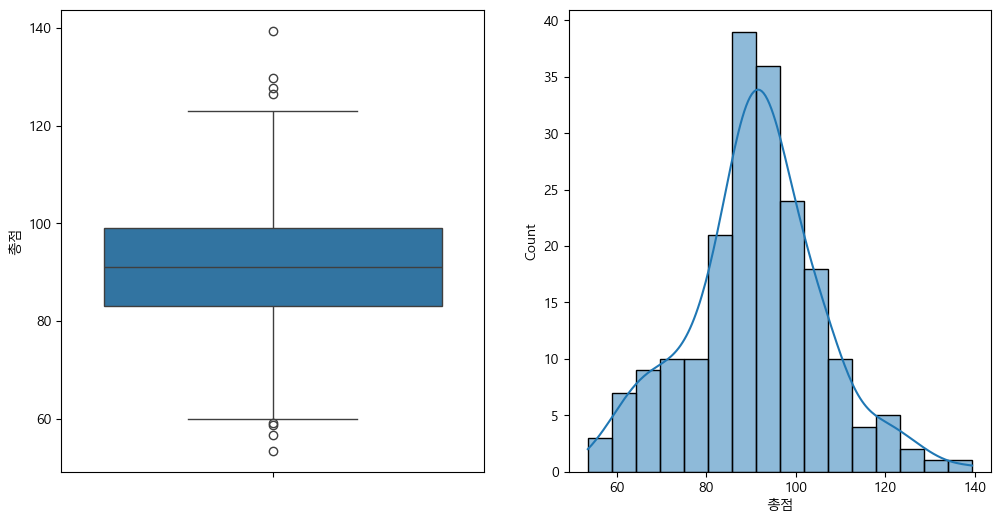

In [9]:
def grade(df):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.boxplot(data=df, y='총점')

    plt.subplot(1,2,2)
    sns.histplot(data=df, x='총점', kde=True)
    plt.show()
grade(df)

- A+ : 110이상, A0 : 100이상, B+ : 90이상, B0 : 80이상, C  : 70이상, D : 60이상, 그외 : F \
이와 같이 설정한다

In [10]:
def grade(score):
    if score >= 110:
        return 'A+'
    elif score >= 100:
        return 'A0'
    elif score >= 90:
        return 'B+'
    elif score  >= 80:
        return 'B0'
    elif score >= 70:
        return 'C'
    elif score >= 60:
        return 'D'
    else:
        return 'F'
df['학점']= df['총점'].apply(grade)

In [11]:
df['학점'].value_counts()

학점
B+    68
B0    48
A0    29
C     20
A+    16
D     15
F      4
Name: count, dtype: int64

### **2. 모델링**


2.1 전체 변수 활용한 OLS 평가

In [12]:
x=df[['하루공부시간', '과제투자시간', '출석률', 'SNS사용시간', '게임시간', '카페인섭취량(mg)']]
y=df['총점']
x=sm.add_constant(x)
model=sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     총점   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     266.8
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           1.43e-90
Time:                        15:59:34   Log-Likelihood:                -600.52
No. Observations:                 200   AIC:                             1215.
Df Residuals:                     193   BIC:                             1238.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.7791      6.972     -1.689      0.093     -25.530       1.972
하루공부시간         9.9102      0.321     30.912      0.000       9.278      10.543
과제투자시간         8.0005      0.370     21.646      0.000       7.271       8.729
출석률            0.6329      0.073      8.627      0.000       0.488       0.778
SNS사용시간        0.1323      0.306      0.433      0.666      -0.471       0.735
게임시간          -0.0322      0.390     -0.083      0.934      -0.801       0.736
카페인섭취량(mg)    -0.0003      0.007     -0.039      0.969      -0.014       0.013
==============================================================================
Omnibus:                        0.257   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.228
Skew:                           0.081   Prob(JB):                        0.892
Kurtosis:                       2.970   Cond. No.                     3.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

4.2 모델 간소화 (P>|t| 값이 0.05인 변수 제거)

In [13]:
x1=df[['하루공부시간', '과제투자시간', '출석률']]
y1=df['총점']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x1,y1,test_size=0.2, random_state=42)

model3=LinearRegression()
model3.fit(x_train, y_train)

y_train_pred=model3.predict(x_train)
y_test_pred=model3.predict(x_test)

- 모델 성능 평가

In [14]:
def model3_evaluate(df):
    train_rmse = mean_squared_error(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)
    print('Train RMSE :', np.sqrt(train_rmse))
    print('Test_RMSE :', np.sqrt(test_rmse))
model3_evaluate(df)

Train RMSE : 4.668061438037696
Test_RMSE : 5.828805595897334


- Train셋과 Test셋의 RMSE값이 약 1.2 차이. 총점의 범위가 0~약 100점의 범위이므로 성능이 꽤 괜찮음을 알 수 있음

4.3 예측값과 실제값 차이 시각화

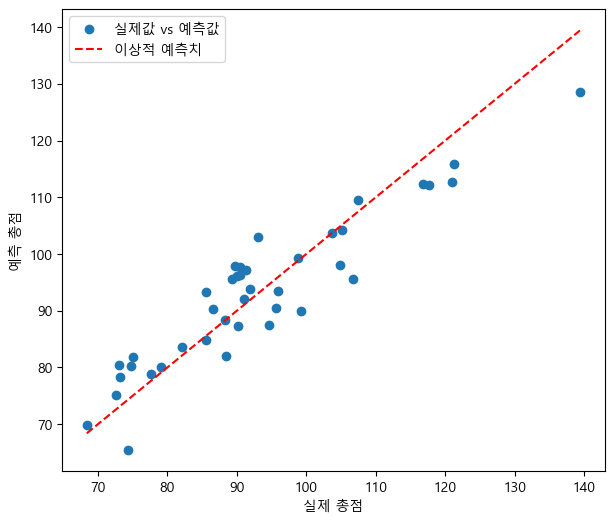

In [15]:
def linear3_visual(df):
    plt.figure(figsize=(7,6))
    plt.scatter(y_test, y_test_pred, label='실제값 vs 예측값')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='이상적 예측치')
    plt.xlabel('실제 총점')
    plt.ylabel('예측 총점')
    plt.legend()
    plt.show()
linear3_visual(df)

### **3. 재시도**

- 모델 학습 전 변수들의 범위를 표준화 혹은 정규화 했어야 했지만, 이를 망각하고 지금까지 학습함. 따라서, 표준화, 정규화가 모델 학습에 얼마나 영향을 미치는지 알아보기로 함

3.1 변수 재설정

In [16]:
a=df[['하루공부시간', '과제투자시간', '출석률']]
b=df['총점']
a_train, a_test, b_train, b_test = train_test_split(a,b,test_size=0.2, random_state=42)

3.2 표준화

In [17]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
a_train_scaled=scaler.fit_transform(a_train)
a_test_scaled=scaler.transform(a_test)

3.3 모델학습 & 예측

In [18]:
model4=LinearRegression()
model4.fit(a_train_scaled, b_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
b_train_pred=model4.predict(a_train_scaled)
b_test_pred=model4.predict(a_test_scaled)

3.4 성능평가

In [20]:
def linear4_evaluate(df):
    print('Train RMSE:', np.sqrt(mean_squared_error(b_train, b_train_pred)))
    print('Test RMSE:', np.sqrt(mean_squared_error(b_test, b_test_pred)))
linear4_evaluate(df)

Train RMSE: 4.668061438037697
Test RMSE: 5.828805595897327


- 표쥰화 전과 후의 성능차이가 그렇게 크지 않다. 이 이유는 다음과 같이 설명 가능하다 
- 변수의 스케일이 그렇게 큰 차이가 없다는 점이다. 시간 관련 변수이기에 0~24 사이의 값이 주류이고, 출석률도 백분율 값이기에 100이 최대치이다. 따라서 표준화가 중요하지 않아 보일 순 있다.